<a href="https://colab.research.google.com/github/javahedi/project-On-GoogleColab/blob/main/dnn_FuelEfficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In ML and DL applications, we can encounter various data features:
- numerical data
  1. continuous
  2. discrete
- unordered categorial (nominal) data
- ordered categorial (ordinal) data



In [ ]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

"""
Attribute Information:
 
1. mpg:           continuous
2. cylinders:     multi-valued discrete
3. displacement:  continuous
4. horsepower:    continuous
5. weight:        continuous
6. acceleration:  continuous
7. model year:    multi-valued discrete
8. origin:        multi-valued discrete
9. car name:      string (unique for each instance)
"""

column_name = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight' , 'acceleration', 'model year', 'origin', 'car name']


df = pd.read_csv(url, names= column_name, sep='\s+', na_values="?")

df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [ ]:
# remove  last column
df = df.drop(columns=['car name'])

In [ ]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
df.isnull().sum()
if df.isnull().sum().sum()>0:
  df = df.dropna()
  df = df.reset_index(drop=True)

In [ ]:
from os import terminal_size
import sklearn 
import sklearn.model_selection 

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=42)

In [ ]:
df_train.shape

(313, 8)

In [ ]:
# numeric columns
numeric_column_names = ['cylinders', 'displacement', 'horsepower', 'weight' , 'acceleration']

In [ ]:
train_state = df_train[numeric_column_names].describe().transpose()
train_state

,count,mean,std,min,25%,50%,75%,max
cylinders,313.0,5.482428,1.700446,3.0,4.0,4.0,8.0,8.0
displacement,313.0,195.517572,103.766567,70.0,105.0,151.0,302.0,455.0
horsepower,313.0,104.594249,38.283669,46.0,76.0,95.0,129.0,230.0
weight,313.0,2986.124601,841.133957,1613.0,2234.0,2855.0,3645.0,5140.0
acceleration,313.0,15.544089,2.817864,8.0,13.5,15.5,17.3,24.8


In [ ]:
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

In [ ]:
for col_name in numeric_column_names:
  mean = train_state.loc[col_name, 'mean']
  std = train_state.loc[col_name, 'std']
  df_train_norm.loc[:,col_name] = (df_train_norm.loc[:,col_name] - mean) / std
  df_test_norm.loc[:,col_name] = (df_test_norm.loc[:,col_name] - mean) / std

df_train_norm.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
71,15.0,1.480536,1.045447,1.186034,1.076969,-1.080283,72,1
106,18.0,0.304374,0.351582,-0.120005,-0.234356,-0.193086,73,1
270,23.8,-0.871788,-0.429017,-0.511817,-0.155890,0.729599,78,1
348,29.9,-0.871788,-0.939778,-1.034233,-0.720604,1.829723,81,1
102,11.0,1.480536,1.970600,1.186034,2.390672,-0.547965,73,1


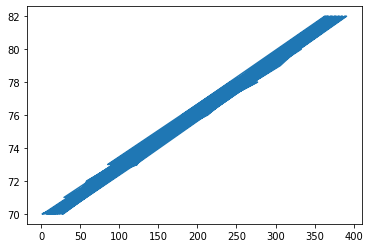

In [ ]:
df_train_norm['model year'].plot.line()
 

lets **bucket** the "yeal model" as

$
X =
\begin{cases}
0 & \text{if year $<73$} \\
1 & \text{if $73\le$ year $<76$} \\
2 & \text{if $76\le$ year $<79$} \\
3 & \text{if year $\ge 79$} 
\end{cases}
$

- note that th chosen interval was selected arbitrarily

In [ ]:
import torch

In [ ]:
boundaries = torch.tensor([73,76,79])
v = torch.tensor(df_train_norm['model year'].values)
df_train_norm['model year bucketed'] = torch.bucketize(v, boundaries, right=True)
v = torch.tensor(df_test_norm['model year'].values)
df_test_norm['model year bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('model year bucketed')

Next, lets, deal with "origin" --> unordered-categorical feature

in **PyTorch**, there are two ways to deal with categorical featuers.
  1. embeding layer--> "nn.Embedding"
     > maps each index to a vector of random number (type float)
  2. one-hot-encoded vectors, for instanse:
    > index 0 --> [1,0,0]
    > index 1 --> [0,1,0]
    > ... 

In [ ]:
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['origin'])) # set , very fats, to find all unique in a list or array


In [ ]:
# trian set
origin_encoded = one_hot(torch.from_numpy(df_train_norm['origin'].values) % total_origin ) # change 1,2,3 to 1,2,0
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

In [ ]:
torch.from_numpy(df_train_norm['origin'].values) % total_origin

tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1,
        2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1,
        2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1,
        0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2,
        1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1,
        1, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1,

In [ ]:
origin_encoded[:5]

tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])

In [ ]:
# test set
origin_encoded = one_hot(torch.from_numpy(df_test_norm['origin'].values) % total_origin ) # change 1,2,3 to 1,2,0
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [ ]:
y_train = torch.tensor(df_train_norm['mpg'].values).float()
y_test = torch.tensor(df_test_norm['mpg'].values).float()

- trining DNN regression mode
- we will create "dataLoader" with bachSize=8

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

In [ ]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(42)
trains_dl = DataLoader(train_ds, batch_size, shuffle=True)


Now:
 - we bulid a DNN model, with two fully connected layers
 - where one has 8 hidden ubits
 - another has 4 hidden units

In [ ]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []

for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)
model


Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Now let's train the model

In [ ]:
torch.manual_seed(42)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0 
    for x_batch, y_batch in trains_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch:3d}  Loss  '
              f'{loss_hist_train/len(trains_dl):.4f}')

Epoch   0  Loss6.1328
Epoch  20  Loss6.1171
Epoch  40  Loss5.9746
Epoch  60  Loss6.2931
Epoch  80  Loss6.0356
Epoch 100  Loss5.8705
Epoch 120  Loss6.1071
Epoch 140  Loss5.9009
Epoch 160  Loss5.8409
Epoch 180  Loss6.2237


**We can now evaluate the regression performance of the trained mode on the test set**

In [ ]:
with torch.no_grad():
    pred = model(x_test.float())[:,0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE : {loss.item():.4f}')
    print(f'Test MAE : {nn.L1Loss()(pred, y_test).item():.4f}')


Test MSE : 20.7486
Test MAE : 3.4824
